In [4]:
from importlib import reload
import matplotlib.pyplot as plt
from scipy import spatial
import numpy as np
from scipy.linalg import eig, eigh
import os

import merger_tree_tools as mtt
import snapshot_tools as st
import halo_tools as ht
import galaxy_tools as gt
from time import sleep, perf_counter

from halomod import TracerHaloModel
import halomod
import hmf

In [5]:
mtt=reload(mtt)
st=reload(st)
ht=reload(ht)
gt=reload(gt)

In [6]:
snap1=st.SnapshotTools('/fred/oz009/cpower/L31pt25_N512_2LPT/HiSURFS_L31pt25_0076/HiSURFS_L31pt25_0076','HDF5', convention='SWIFT',positions_only=False)
halo1=ht.HaloTools('/fred/oz009/cpower/L31pt25_N512_2LPT/halos/HiSURFS_L31pt25_0076.VELOCIraptor','VELOCIraptor')
tree1=mtt.TreeTools('/fred/oz009/cpower/L31pt25_N512_2LPT/trees/VELOCIraptor.walkabletree.forestID.hdf5.0','TreeFrog')
gal1=gt.GalaxyTools('/fred/oz009/mzhang/shark_output/L31pt25_N512_2LPT_Ming/lagos23/76/allgalaxies.hdf5','SHARK')

snap1.ReadSnapshot()
halo1.ReadHaloCatalogue()
tree1.ReadMergerTreeCatalogue()
gal1.ReadGalaxyCatalogue()

snap2=st.SnapshotTools('/fred/oz009/cpower/L62pt5_N512_2LPT/HiSURFS_L62pt5_0076/HiSURFS_L62pt5_0076','HDF5', convention='SWIFT',positions_only=False)
halo2=ht.HaloTools('/fred/oz009/cpower/L62pt5_N512_2LPT/halos/HiSURFS_L62pt5_0076.VELOCIraptor','VELOCIraptor')
tree2=mtt.TreeTools('/fred/oz009/cpower/L62pt5_N512_2LPT/trees/VELOCIraptor.walkabletree.forestID.hdf5.0','TreeFrog')
gal2=gt.GalaxyTools('/fred/oz009/mzhang/shark_output/L62pt5_N512_2LPT_Ming/lagos23/76/allgalaxies.hdf5','SHARK')

snap2.ReadSnapshot()
halo2.ReadHaloCatalogue()
tree2.ReadMergerTreeCatalogue()
gal2.ReadGalaxyCatalogue()

snap3=st.SnapshotTools('/fred/oz009/cpower/L125_N512_2LPT/HiSURFS_L125_0076/HiSURFS_L125_0076','HDF5', convention='SWIFT',positions_only=False)
halo3=ht.HaloTools('/fred/oz009/cpower/L125_N512_2LPT/halos/HiSURFS_L125_0076.VELOCIraptor','VELOCIraptor')
tree3=mtt.TreeTools('/fred/oz009/cpower/L125_N512_2LPT/trees/VELOCIraptor.walkabletree.forestID.hdf5.0','TreeFrog')
gal3=gt.GalaxyTools('/fred/oz009/mzhang/shark_output/L125_N512_2LPT_Ming/lagos23/76/allgalaxies.hdf5','SHARK')

snap3.ReadSnapshot()
halo3.ReadHaloCatalogue()
tree3.ReadMergerTreeCatalogue()
gal3.ReadGalaxyCatalogue()

snap4=st.SnapshotTools('/fred/oz009/cpower/L250_N512_2LPT/HiSURFS_L250_0076/HiSURFS_L250_0076','HDF5', convention='SWIFT',positions_only=False)
halo4=ht.HaloTools('/fred/oz009/cpower/L250_N512_2LPT/halos/HiSURFS_L250_0076.VELOCIraptor','VELOCIraptor')
tree4=mtt.TreeTools('/fred/oz009/cpower/L250_N512_2LPT/trees/VELOCIraptor.walkabletree.forestID.hdf5.0','TreeFrog')
gal4=gt.GalaxyTools('/fred/oz009/mzhang/shark_output/L250_N512_2LPT_Ming/lagos23/76/allgalaxies.hdf5','SHARK')

snap4.ReadSnapshot()
halo4.ReadHaloCatalogue()
tree4.ReadMergerTreeCatalogue()
gal4.ReadGalaxyCatalogue()

snap5=st.SnapshotTools('/fred/oz009/cpower/L500_N512_2LPT/HiSURFS_L500_0076/HiSURFS_L500_0076','HDF5', convention='SWIFT',positions_only=False)
halo5=ht.HaloTools('/fred/oz009/cpower/L500_N512_2LPT/halos/HiSURFS_L500_0076.VELOCIraptor','VELOCIraptor')
tree5=mtt.TreeTools('/fred/oz009/cpower/L500_N512_2LPT/trees/VELOCIraptor.walkabletree.forestID.hdf5.0','TreeFrog')
gal5=gt.GalaxyTools('/fred/oz009/mzhang/shark_output/L500_N512_2LPT_Ming/lagos23/76/allgalaxies.hdf5','SHARK')

snap5.ReadSnapshot()
halo5.ReadHaloCatalogue()
tree5.ReadMergerTreeCatalogue()
gal5.ReadGalaxyCatalogue()

snap6=st.SnapshotTools('/fred/oz009/cpower/L1000_N512_2LPT/HiSURFS_L1000_0076/HiSURFS_L1000_0076','HDF5', convention='SWIFT',positions_only=False)
halo6=ht.HaloTools('/fred/oz009/cpower/L1000_N512_2LPT/halos/HiSURFS_L1000_0076.VELOCIraptor','VELOCIraptor')
tree6=mtt.TreeTools('/fred/oz009/cpower/L1000_N512_2LPT/trees/VELOCIraptor.walkabletree.forestID.hdf5.0','TreeFrog')
gal6=gt.GalaxyTools('/fred/oz009/mzhang/shark_output/L1000_N512_2LPT_Ming/lagos23/76/allgalaxies.hdf5','SHARK')

snap6.ReadSnapshot()
halo6.ReadHaloCatalogue()
tree6.ReadMergerTreeCatalogue()
gal6.ReadGalaxyCatalogue()

Reading data from /fred/oz009/cpower/L31pt25_N512_2LPT/HiSURFS_L31pt25_0076/HiSURFS_L31pt25_0076.hdf5
Simulation scale factor: 1.000000
Number of particles: 0134217728
Number of particle types: 7
Reading data for 91939 groups
['File_id', 'Group_Size', 'Num_of_files', 'Num_of_groups', 'Number_of_substructures_in_halo', 'Offset', 'Offset_unbound', 'Parent_halo_ID', 'Total_num_of_groups']
Reading data for 91939 groups
Reading data for 69487931 particles in groups
Reading data for 3316001 particles in groups
Found data for 077 snapshots in file...
Reading data from /fred/oz009/mzhang/shark_output/L31pt25_N512_2LPT_Ming/lagos23/76/allgalaxies.hdf5
<KeysViewHDF5 ['bh_accretion_rate_hh', 'bh_accretion_rate_sb', 'bh_spin', 'bolometric_luminosity_agn', 'cnfw_subhalo', 'cooling_rate', 'descendant_id_galaxy', 'id_galaxy', 'id_halo', 'id_halo_tree', 'id_subhalo', 'id_subhalo_tree', 'l_x', 'l_y', 'l_z', 'lambda_subhalo', 'm_bh', 'm_bh_assembly', 'matom_bulge', 'matom_disk', 'mean_mstellar_galaxies_

In [ ]:
# import h5py

# file_path = '/fred/oz009/cpower/L125_N512_2LPT/halos/HiSURFS_L125_0076.VELOCIraptor.properties.0'

# # 打开 HDF 文件
# with h5py.File(file_path, 'r') as file:
#     # 列出文件中的所有数据集
#     def print_hdf5_structure(name, obj):
#         if isinstance(obj, h5py.Dataset):
#             print(f"Dataset: {name} - Shape: {obj.shape} - Data Type: {obj.dtype}")
#         elif isinstance(obj, h5py.Group):
#             print(f"Group: {name}")

#     file.visititems(print_hdf5_structure)


In [ ]:
# import h5py
# import os

# # 定义输入文件的基础目录
# input_base_dir = '/fred/oz009/achandro/shark_output/L1000_N512_2LPT_Ming/lagos23/76/'

# # 定义输出文件路径
# output_base_dir = '/fred/oz009/mzhang/shark_output/L1000_N512_2LPT_Ming/lagos23/76/'
# output_file = os.path.join(output_base_dir, 'allgalaxies.hdf5')

# # 确保输出目录存在，如果不存在则创建
# os.makedirs(output_base_dir, exist_ok=True)

# # 获取所有输入文件的路径
# input_files = [os.path.join(input_base_dir, str(i), 'galaxies.hdf5') for i in range(64)]

# # 递归合并组和数据集的辅助函数
# def merge_group(source_group, target_group):
#     for key, obj in source_group.items():
#         if isinstance(obj, h5py.Group):  # 如果是组，递归合并
#             if key not in target_group:
#                 target_subgroup = target_group.create_group(key)
#             else:
#                 target_subgroup = target_group[key]
#             merge_group(obj, target_subgroup)
#         elif isinstance(obj, h5py.Dataset):  # 如果是数据集，合并数据
#             if key in target_group:  # 如果数据集已经存在
#                 existing_data = target_group[key]
#                 new_size = existing_data.shape[0] + obj.shape[0]
#                 existing_data.resize(new_size, axis=0)
#                 existing_data[-obj.shape[0]:] = obj[:]
#             else:  # 如果数据集不存在，创建新的数据集
#                 maxshape = (None,) + obj.shape[1:]  # 设置第一维可以增长
#                 target_group.create_dataset(
#                     key,
#                     data=obj[:],
#                     maxshape=maxshape,
#                     chunks=True,
#                     compression="gzip"
#                 )
#         else:
#             print(f"未知对象类型，跳过：{key}")

# # 创建输出HDF5文件
# with h5py.File(output_file, 'w') as hdf_out:
#     for file_index, input_file in enumerate(input_files):
#         if not os.path.exists(input_file):
#             print(f"文件不存在，跳过：{input_file}")
#             continue
#         with h5py.File(input_file, 'r') as hdf_in:
#             # 检查是否有名为 'galaxies' 的组，并处理
#             if 'galaxies' in hdf_in:
#                 if 'galaxies' not in hdf_out:
#                     hdf_out.create_group('galaxies')
#                 merge_group(hdf_in['galaxies'], hdf_out['galaxies'])
#             else:
#                 print(f"文件 {input_file} 中不存在 'galaxies' 组，跳过")
#         print(f"已合并文件 {file_index + 1}/{len(input_files)}: {input_file}")

# print(f"合并完成，输出文件保存到：{output_file}")



In [12]:
final_snap_num=76
halo_list=np.logical_and(halo1.Structuretype==10,halo1.GroupMFOF>snap1.Particle_mass*600)
main_subhalo_list=halo1.GroupID[halo_list]

# print(gal1.vel)
# print(gal1.haloid)
# print(len(gal1.haloid))
# print(gal1.subhaloid)
# print(gal1.galaxyid)
# print(len(halo1.GroupID))
# print(halo1.GroupID[halo_list])
# print(halo1.ParentHaloID)
G=43
ihalo=0
for main_halo in main_subhalo_list:
    halo_id=np.where(main_halo==halo1.GroupID)[0]
    subhalo_ids = np.where(halo_id+1==halo1.ParentHaloID)
    print(len(subhalo_ids[0]))
    # print(halo_id, main_halo, final_snap_num)

904
979
650
616
410
464
331
322
266
269
246
289
268
202
163
153
145
113
109
94
76
130
107
77
84
70
123
64
98
97
53
68
83
73
30
91
68
88
66
40
47
79
77
69
95
81
43
44
36
33
46
25
48
46
78
42
45
37
50
26
20
35
37
25
20
41
45
32
49
32
20
30
20
30
38
42
32
25
30
25
36
38
10
47
26
30
25
27
18
19
13
21
34
16
20
26
25
17
37
26
16
20
22
16
32
14
18
29
9
14
19
29
25
25
17
25
13
9
26
33
21
12
12
27
5
29
14
21
12
22
15
9
15
13
10
20
15
21
13
19
3
21
14
11
18
7
9
13
25
5
17
10
34
31
13
8
11
16
16
9
11
7
7
20
3
9
12
10
21
11
9
14
11
14
22
17
11
10
10
25
11
10
17
11
6
8
11
13
24
12
5
10
16
4
13
23
9
9
8
19
22
5
11
9
13
12
12
11
22
11
11
15
11
11
13
18
11
6
10
8
8
9
7
5
8
5
11
7
10
12
8
6
6
7
8
10
18
4
3
8
12
3
5
13
13
10
19
11
10
12
12
7
4
8
12
10
12
8
19
14
7
9
8
8
3
10
4
15
5
14
5
11
6
7
3
8
5
10
10
5
9
9
9
8
4
8
1
2
12
4
4
3
11
9
6
12
6
8
8
5
11
12
11
7
2
10
6
9
10
7
10
4
5
0
15
3
11
11
13
4
9
18
4
5
6
7
1
8
5
5
4
5
5
8
3
5
6
4
5
4
2
6
5
4
5
3
4
5
13
4
7
9
6
7
3
4
5
11
4
4
9
2
4
13
3
8
4
3
4
5
4


In [14]:
final_snap_num=76
halo_list=np.logical_and(halo1.Structuretype==10,halo1.GroupMFOF>snap1.Particle_mass*600)

main_subhalo_list=halo1.GroupID[halo_list]
print("Tracking merger histories for %04d halos"%main_subhalo_list.size)

NumGroups=main_subhalo_list.size
print(NumGroups)

halo1_m200=np.zeros(NumGroups)
veldisp1_sub=np.zeros(NumGroups)
veldisp1_gal=np.zeros(NumGroups)
num_gal1=np.zeros(NumGroups)

G=43
ihalo=0
for main_halo in main_subhalo_list:
    halo_id=np.where(main_halo==halo1.GroupID)[0]
    # print(halo_id, main_halo, final_snap_num)
    redshift,mass,m200,group_number,subhalo_number,zform,alpha=tree1.TrackMainHaloProgenitor(main_halo,final_snap_num)
    
    if len(mass)>0:
        # assemble history
        # formation_redshift[ihalo]=zform
        # alpha03[ihalo]=alpha

        # general properties
        # halo_masstot[ihalo]=mass[0]
        halo1_m200[ihalo]=m200[0]

        subhalo_ids = np.where(halo_id+1==halo1.ParentHaloID)#[0]
        for subhalo_id in subhalo_ids:
            if len(halo1.GroupM200[subhalo_id]) > 2:
                # m200_sub[ihalo] = np.max(halo.GroupM200[subhalo_id])
                # mvir_sub[ihalo] = np.max(halo.GroupMvir[subhalo_id])
                # mtot_sub[ihalo] = np.max(halo.GroupMass[subhalo_id])
                # mfof_sub[ihalo] = np.max(halo.GroupMFOF[subhalo_id])
                
                # Vmax_sub[ihalo] = np.max(halo.Vmax[subhalo_id])
                veldisp1_sub[ihalo] = np.linalg.norm(np.std(halo1.GroupVel[subhalo_id],axis=0))
                # veldisp1_gal[ihalo] = np.linalg.norm(np.std(gal1.vel[subhalo_id],axis=0))
                # vel_sub[ihalo] = np.std(halo.GroupVel[subhalo_id])
            else:
                # m200_sub[ihalo] = 0  
                # Vmax_sub[ihalo] = 0
                veldisp1_sub[ihalo] = 0
                veldisp1_gal[ihalo] = 0

        galaxy_ids = np.where(halo_id+1==gal1.haloid)
        num_gal1[ihalo] = len(galaxy_ids[0])
        for galaxy_id in galaxy_ids:
            # if len(halo1.GroupM200[galaxy_id]) > 2:
            veldisp1_gal[ihalo] = np.linalg.norm(np.std(gal1.vel[galaxy_id],axis=0))
            # else:
            #     veldisp1_gal[ihalo] = 0

    ihalo+=1

print(halo1_m200,veldisp1_sub,veldisp1_gal,num_gal1)

Tracking merger histories for 6228 halos
6228
[3.99800249e+03 3.44342747e+03 1.97570081e+03 ... 4.19213702e-01
 4.35254189e-01 4.72547592e-01] [622.21049148 554.38746871 449.31395926 ...   0.           0.
   0.        ] [384.49728394 221.63145447 215.40815735 ...          nan          nan
          nan] [12875.  3093.  1848. ...     0.     0.     0.]


In [15]:
final_snap_num=76
halo_list=np.logical_and(halo2.Structuretype==10,halo2.GroupMFOF>snap2.Particle_mass*600)

main_subhalo_list=halo2.GroupID[halo_list]
print("Tracking merger histories for %04d halos"%main_subhalo_list.size)

NumGroups=main_subhalo_list.size
print(NumGroups)

halo2_m200=np.zeros(NumGroups)
veldisp2_sub=np.zeros(NumGroups)
veldisp2_gal=np.zeros(NumGroups)
num_gal2=np.zeros(NumGroups)

G=43
ihalo=0
for main_halo in main_subhalo_list:
    halo_id=np.where(main_halo==halo2.GroupID)[0]
    # print(halo_id, main_halo, final_snap_num)
    redshift,mass,m200,group_number,subhalo_number,zform,alpha=tree2.TrackMainHaloProgenitor(main_halo,final_snap_num)
    
    if len(mass)>0:
        # assemble history
        # formation_redshift[ihalo]=zform
        # alpha03[ihalo]=alpha

        # general properties
        # halo_masstot[ihalo]=mass[0]
        halo2_m200[ihalo]=m200[0]

        subhalo_ids = np.where(halo_id+1==halo2.ParentHaloID)#[0]
        for subhalo_id in subhalo_ids:
            if len(halo2.GroupM200[subhalo_id]) > 2:
                # m200_sub[ihalo] = np.max(halo.GroupM200[subhalo_id])
                # mvir_sub[ihalo] = np.max(halo.GroupMvir[subhalo_id])
                # mtot_sub[ihalo] = np.max(halo.GroupMass[subhalo_id])
                # mfof_sub[ihalo] = np.max(halo.GroupMFOF[subhalo_id])
                
                # Vmax_sub[ihalo] = np.max(halo.Vmax[subhalo_id])
                veldisp2_sub[ihalo] = np.linalg.norm(np.std(halo2.GroupVel[subhalo_id],axis=0))
                # vel_sub[ihalo] = np.std(halo.GroupVel[subhalo_id])
            else:
                # m200_sub[ihalo] = 0  
                # Vmax_sub[ihalo] = 0
                veldisp2_sub[ihalo] = 0

        galaxy_ids = np.where(halo_id+1==gal2.haloid)
        num_gal2[ihalo] = len(galaxy_ids[0])
        for galaxy_id in galaxy_ids:
            # if len(halo2.GroupM200[galaxy_id]) > 0:
            veldisp2_gal[ihalo] = np.linalg.norm(np.std(gal2.vel[galaxy_id],axis=0))
            # else:
                # veldisp2_gal[ihalo] = 0


    ihalo+=1

print(halo2_m200,veldisp2_sub)

Tracking merger histories for 7583 halos
7583
[2.60674472e+04 8.31887585e+03 1.16517120e+04 ... 3.88629718e+00
 3.89769441e+00 3.41967927e+00] [1103.70470729  749.53449028  869.21039992 ...    0.            0.
    0.        ]


In [16]:
final_snap_num=76
halo_list=np.logical_and(halo3.Structuretype==10,halo3.GroupMFOF>snap3.Particle_mass*600)

main_subhalo_list=halo3.GroupID[halo_list]
print("Tracking merger histories for %04d halos"%main_subhalo_list.size)

NumGroups=main_subhalo_list.size
print(NumGroups)

halo3_m200=np.zeros(NumGroups)
veldisp3_sub=np.zeros(NumGroups)
veldisp3_gal=np.zeros(NumGroups)
num_gal3=np.zeros(NumGroups)

G=43
ihalo=0
for main_halo in main_subhalo_list:
    halo_id=np.where(main_halo==halo3.GroupID)[0]
    # print(halo_id, main_halo, final_snap_num)
    redshift,mass,m200,group_number,subhalo_number,zform,alpha=tree3.TrackMainHaloProgenitor(main_halo,final_snap_num)
    
    if len(mass)>0:
        # assemble history
        # formation_redshift[ihalo]=zform
        # alpha03[ihalo]=alpha

        # general properties
        # halo_masstot[ihalo]=mass[0]
        halo3_m200[ihalo]=m200[0]

        subhalo_ids = np.where(halo_id+1==halo3.ParentHaloID)#[0]
        for subhalo_id in subhalo_ids:
            if len(halo3.GroupM200[subhalo_id]) > 2:
                # m200_sub[ihalo] = np.max(halo.GroupM200[subhalo_id])
                # mvir_sub[ihalo] = np.max(halo.GroupMvir[subhalo_id])
                # mtot_sub[ihalo] = np.max(halo.GroupMass[subhalo_id])
                # mfof_sub[ihalo] = np.max(halo.GroupMFOF[subhalo_id])
                
                # Vmax_sub[ihalo] = np.max(halo.Vmax[subhalo_id])
                veldisp3_sub[ihalo] = np.linalg.norm(np.std(halo3.GroupVel[subhalo_id],axis=0))
                # vel_sub[ihalo] = np.std(halo.GroupVel[subhalo_id])
            else:
                # m200_sub[ihalo] = 0  
                # Vmax_sub[ihalo] = 0
                veldisp3_sub[ihalo] = 0
                
        galaxy_ids = np.where(halo_id+1==gal3.haloid)
        num_gal3[ihalo] = len(galaxy_ids[0])
        for galaxy_id in galaxy_ids:
            # if len(halo3.GroupM200[galaxy_id]) > 0:
            veldisp3_gal[ihalo] = np.linalg.norm(np.std(gal3.vel[galaxy_id],axis=0))
            # else:
                # veldisp3_gal[ihalo] = 0

    ihalo+=1

print(halo3_m200,veldisp3_sub)

Tracking merger histories for 9430 halos
9430
[4.27342839e+04 1.73032111e+04 0.00000000e+00 ... 2.70246187e+01
 2.48529887e+01 1.99599901e+01] [1253.22858237 1050.81827657    0.         ...    0.            0.
    0.        ]


In [17]:
final_snap_num=76
halo_list=np.logical_and(halo4.Structuretype==10,halo4.GroupMFOF>snap4.Particle_mass*600)

main_subhalo_list=halo4.GroupID[halo_list]
print("Tracking merger histories for %04d halos"%main_subhalo_list.size)

NumGroups=main_subhalo_list.size
print(NumGroups)

halo4_m200=np.zeros(NumGroups)
veldisp4_sub=np.zeros(NumGroups)
veldisp4_gal=np.zeros(NumGroups)
num_gal4=np.zeros(NumGroups)

G=43
ihalo=0
for main_halo in main_subhalo_list:
    halo_id=np.where(main_halo==halo4.GroupID)[0]
    # print(halo_id, main_halo, final_snap_num)
    redshift,mass,m200,group_number,subhalo_number,zform,alpha=tree4.TrackMainHaloProgenitor(main_halo,final_snap_num)
    
    if len(mass)>0:
        # assemble history
        # formation_redshift[ihalo]=zform
        # alpha03[ihalo]=alpha

        # general properties
        # halo_masstot[ihalo]=mass[0]
        halo4_m200[ihalo]=m200[0]

        subhalo_ids = np.where(halo_id+1==halo4.ParentHaloID)#[0]
        for subhalo_id in subhalo_ids:
            if len(halo4.GroupM200[subhalo_id]) > 2:
                # m200_sub[ihalo] = np.max(halo.GroupM200[subhalo_id])
                # mvir_sub[ihalo] = np.max(halo.GroupMvir[subhalo_id])
                # mtot_sub[ihalo] = np.max(halo.GroupMass[subhalo_id])
                # mfof_sub[ihalo] = np.max(halo.GroupMFOF[subhalo_id])
                
                # Vmax_sub[ihalo] = np.max(halo.Vmax[subhalo_id])
                veldisp4_sub[ihalo] = np.linalg.norm(np.std(halo4.GroupVel[subhalo_id],axis=0))
                # vel_sub[ihalo] = np.std(halo.GroupVel[subhalo_id])
            else:
                # m200_sub[ihalo] = 0  
                # Vmax_sub[ihalo] = 0
                veldisp4_sub[ihalo] = 0

        galaxy_ids = np.where(halo_id+1==gal4.haloid)
        num_gal4[ihalo] = len(galaxy_ids[0])
        for galaxy_id in galaxy_ids:
            # if len(halo4.GroupM200[galaxy_id]) > 0:
            veldisp4_gal[ihalo] = np.linalg.norm(np.std(gal4.vel[galaxy_id],axis=0))
            # else:
                # veldisp4_gal[ihalo] = 0

    ihalo+=1

print(halo4_m200,veldisp4_sub)

Tracking merger histories for 11718 halos
11718
[98099.8862714  68837.89514486 46500.01459207 ...   201.75481901
   237.17151645   215.34547901] [1758.23959176 1561.629424   1238.41703282 ...    0.            0.
    0.        ]


In [18]:
final_snap_num=76
halo_list=np.logical_and(halo5.Structuretype==10,halo5.GroupMFOF>snap5.Particle_mass*600)

main_subhalo_list=halo5.GroupID[halo_list]
print("Tracking merger histories for %04d halos"%main_subhalo_list.size)

NumGroups=main_subhalo_list.size
print(NumGroups)

halo5_m200=np.zeros(NumGroups)
veldisp5_sub=np.zeros(NumGroups)
veldisp5_gal=np.zeros(NumGroups)
num_gal5=np.zeros(NumGroups)

G=43
ihalo=0
for main_halo in main_subhalo_list:
    halo_id=np.where(main_halo==halo5.GroupID)[0]
    # print(halo_id, main_halo, final_snap_num)
    redshift,mass,m200,group_number,subhalo_number,zform,alpha=tree5.TrackMainHaloProgenitor(main_halo,final_snap_num)
    
    if len(mass)>0:
        # assemble history
        # formation_redshift[ihalo]=zform
        # alpha03[ihalo]=alpha

        # general properties
        # halo_masstot[ihalo]=mass[0]
        halo5_m200[ihalo]=m200[0]

        subhalo_ids = np.where(halo_id+1==halo5.ParentHaloID)#[0]
        for subhalo_id in subhalo_ids:
            if len(halo5.GroupM200[subhalo_id]) > 2:
                # m200_sub[ihalo] = np.max(halo.GroupM200[subhalo_id])
                # mvir_sub[ihalo] = np.max(halo.GroupMvir[subhalo_id])
                # mtot_sub[ihalo] = np.max(halo.GroupMass[subhalo_id])
                # mfof_sub[ihalo] = np.max(halo.GroupMFOF[subhalo_id])
                
                # Vmax_sub[ihalo] = np.max(halo.Vmax[subhalo_id])
                veldisp5_sub[ihalo] = np.linalg.norm(np.std(halo5.GroupVel[subhalo_id],axis=0))
                # vel_sub[ihalo] = np.std(halo.GroupVel[subhalo_id])
            else:
                # m200_sub[ihalo] = 0  
                # Vmax_sub[ihalo] = 0
                veldisp5_sub[ihalo] = 0

        galaxy_ids = np.where(halo_id+1==gal5.haloid)
        num_gal5[ihalo] = len(galaxy_ids[0])
        for galaxy_id in galaxy_ids:
            # if len(halo5.GroupM200[galaxy_id]) > 0:
            veldisp5_gal[ihalo] = np.linalg.norm(np.std(gal5.vel[galaxy_id],axis=0))
            # else:
                # veldisp5_gal[ihalo] = 0

    ihalo+=1

print(halo5_m200,veldisp5_sub)

Tracking merger histories for 12586 halos
12586
[177294.5168117  133489.49755842  85208.18256504 ...   1698.164363
   1801.16321446   1390.39331594] [2153.76003092 1799.84999749 1603.74097357 ...    0.            0.
    0.        ]


In [19]:
final_snap_num=76
halo_list=np.logical_and(halo6.Structuretype==10,halo6.GroupMFOF>snap6.Particle_mass*600)

main_subhalo_list=halo6.GroupID[halo_list]
print("Tracking merger histories for %04d halos"%main_subhalo_list.size)

NumGroups=main_subhalo_list.size
print(NumGroups)

halo6_m200=np.zeros(NumGroups)
veldisp6_sub=np.zeros(NumGroups)
veldisp6_gal=np.zeros(NumGroups)
num_gal6=np.zeros(NumGroups)

G=43
ihalo=0
for main_halo in main_subhalo_list:
    halo_id=np.where(main_halo==halo6.GroupID)[0]
    # print(halo_id, main_halo, final_snap_num)
    redshift,mass,m200,group_number,subhalo_number,zform,alpha=tree6.TrackMainHaloProgenitor(main_halo,final_snap_num)
    
    if len(mass)>0:
        # assemble history
        # formation_redshift[ihalo]=zform
        # alpha03[ihalo]=alpha

        # general properties
        # halo_masstot[ihalo]=mass[0]
        halo6_m200[ihalo]=m200[0]

        subhalo_ids = np.where(halo_id+1==halo6.ParentHaloID)#[0]
        for subhalo_id in subhalo_ids:
            if len(halo6.GroupM200[subhalo_id]) > 2:
                # m200_sub[ihalo] = np.max(halo.GroupM200[subhalo_id])
                # mvir_sub[ihalo] = np.max(halo.GroupMvir[subhalo_id])
                # mtot_sub[ihalo] = np.max(halo.GroupMass[subhalo_id])
                # mfof_sub[ihalo] = np.max(halo.GroupMFOF[subhalo_id])
                
                # Vmax_sub[ihalo] = np.max(halo.Vmax[subhalo_id])
                veldisp6_sub[ihalo] = np.linalg.norm(np.std(halo6.GroupVel[subhalo_id],axis=0))
                # vel_sub[ihalo] = np.std(halo.GroupVel[subhalo_id])
            else:
                # m200_sub[ihalo] = 0  
                # Vmax_sub[ihalo] = 0
                veldisp6_sub[ihalo] = 0

        # galaxy_ids = np.where(halo_id+1==gal6.haloid)
        # num_gal6[ihalo] = len(galaxy_ids[0])
        # for galaxy_id in galaxy_ids:
        #     if len(halo1.GroupM200[galaxy_id]) > 0:
        #         veldisp6_gal[ihalo] = np.linalg.norm(np.std(gal6.vel[galaxy_id],axis=0))
        #     else:
        #         veldisp6_gal[ihalo] = 0

        galaxy_ids = np.where(halo_id+1==gal6.haloid)
        num_gal6[ihalo] = len(galaxy_ids[0])
        for galaxy_id in galaxy_ids:
            # if len(halo6.GroupM200[galaxy_id]) > 0:
            veldisp6_gal[ihalo] = np.linalg.norm(np.std(gal6.vel[galaxy_id],axis=0))
            # else:
                # veldisp6_gal[ihalo] = 0

    ihalo+=1

print(halo6_m200,veldisp6_sub,veldisp6_gal)

Tracking merger histories for 7911 halos
7911
[371238.33737891 249203.79258638 267890.41337986 ...  12112.37353377
   7482.03172526  12111.73958834] [2554.27019987 2448.65909865 2272.47125346 ...    0.            0.
    0.        ] [1988.89990234 1685.04748535 1597.88427734 ...           nan           nan
           nan]


In [20]:
print(np.log10(halo1_m200)+10,np.log10(halo2_m200)+10,np.log10(halo3_m200)+10)

[13.60184306 13.53699094 13.29572118 ...  9.62243547  9.63874296
  9.67444555] [14.4160985  13.92006464 14.06638974 ... 10.58953601 10.59080779
 10.53398538] [14.63077643 14.23812671        -inf ... 11.43175958 11.39537862
 11.30016032]


/tmp/ipykernel_3446620/474914249.py:1: RuntimeWarning: divide by zero encountered in log10
  print(np.log10(halo1_m200)+10,np.log10(halo2_m200)+10,np.log10(halo3_m200)+10)


/tmp/ipykernel_3446620/3772929783.py:5: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(halo1_m200)+10, np.log10(veldisp1_sub), s=2, color='r')
/tmp/ipykernel_3446620/3772929783.py:6: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(halo2_m200)+10, np.log10(veldisp2_sub), s=2, color='r')
/tmp/ipykernel_3446620/3772929783.py:7: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(halo3_m200)+10, np.log10(veldisp3_sub), s=2, color='r')
/tmp/ipykernel_3446620/3772929783.py:8: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(halo4_m200)+10, np.log10(veldisp4_sub), s=2, color='r')
/tmp/ipykernel_3446620/3772929783.py:9: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(halo5_m200)+10, np.log10(veldisp5_sub), s=2, color='r')
/tmp/ipykernel_3446620/3772929783.py:10: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(halo6_m200)+10, np.log10(veldisp6_s

Text(0, 0.5, '$Log_{10}~\\sigma$ [km s$^{-1}$]')

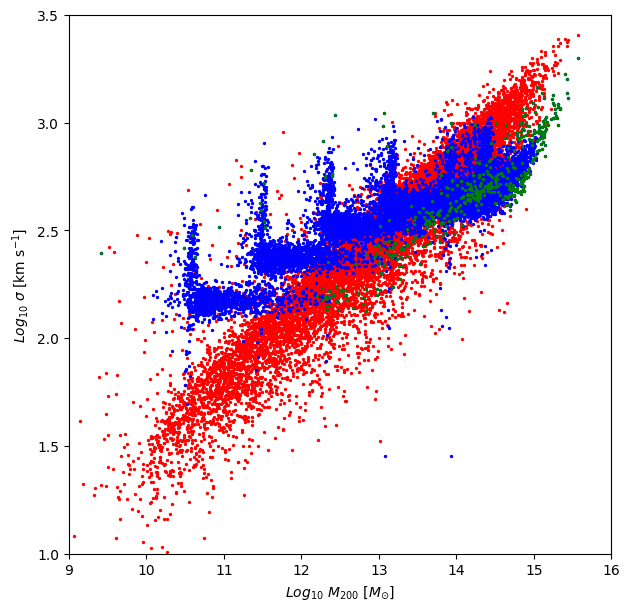

In [27]:
fig=plt.figure(figsize=(7,7))
ax=fig.add_subplot(1,1,1)
# for idx, (dataset, color, label) in enumerate(zip(datasets, colors, labels), start=1):
    # ax.scatter(np.log10(dataset[:, 1])+10, np.log10(dataset[:, 34]**2*dataset[:,5]/43/dataset[:, 1]), s=2, color=color)
ax.scatter(np.log10(halo1_m200)+10, np.log10(veldisp1_sub), s=2, color='r')
ax.scatter(np.log10(halo2_m200)+10, np.log10(veldisp2_sub), s=2, color='r')
ax.scatter(np.log10(halo3_m200)+10, np.log10(veldisp3_sub), s=2, color='r')
ax.scatter(np.log10(halo4_m200)+10, np.log10(veldisp4_sub), s=2, color='r')
ax.scatter(np.log10(halo5_m200)+10, np.log10(veldisp5_sub), s=2, color='r')
ax.scatter(np.log10(halo6_m200)+10, np.log10(veldisp6_sub), s=2, color='r')

ax.scatter(np.log10(halo1_m200)+10, np.log10(veldisp1_gal), s=2,  color='b')
ax.scatter(np.log10(halo2_m200)+10, np.log10(veldisp2_gal), s=2,  color='b')
ax.scatter(np.log10(halo3_m200)+10, np.log10(veldisp3_gal), s=2,  color='b')
ax.scatter(np.log10(halo4_m200)+10, np.log10(veldisp4_gal), s=2,  color='b')
ax.scatter(np.log10(halo5_m200)+10, np.log10(veldisp5_gal), s=2,  color='b')
ax.scatter(np.log10(halo6_m200)+10, np.log10(veldisp6_gal), s=2,  color='b')

ax.scatter(np.log10(halo1_m200[num_gal1>150])+10, np.log10(veldisp1_gal[num_gal1>150]), s=2,  color='g')
ax.scatter(np.log10(halo2_m200[num_gal2>150])+10, np.log10(veldisp2_gal[num_gal2>150]), s=2,  color='g')
ax.scatter(np.log10(halo3_m200[num_gal3>150])+10, np.log10(veldisp3_gal[num_gal3>150]), s=2,  color='g')
ax.scatter(np.log10(halo4_m200[num_gal4>150])+10, np.log10(veldisp4_gal[num_gal4>150]), s=2,  color='g')
ax.scatter(np.log10(halo5_m200[num_gal5>150])+10, np.log10(veldisp5_gal[num_gal5>150]), s=2,  color='g')
ax.scatter(np.log10(halo6_m200[num_gal6>150])+10, np.log10(veldisp6_gal[num_gal6>150]), s=2,  color='g')

# plt.plot(best_fit_x, best_fit_y, color='red', label='Linear Fit')  
plt.ylim(1,3.5) 
plt.xlim(9,16) 
# ax.text(9.6,3.3,'All halos', size=16, color='black')
# ax.text(9.6,3.1,'subhalos', size=16, color='purple')
# ax.text(9.6, 2.9, f'slope={slope:.3f}', size=16, color='red')
ax.set_xlabel(r'$Log_{10}~M_{200}~[M_{\odot}]$')
ax.set_ylabel(r'$Log_{10}~\sigma$ [km s$^{-1}$]')

In [ ]:
# final_snap_num=76
# halo_list=np.logical_and(halo.Structuretype==10,halo.GroupMFOF>snap.Particle_mass*600)

# main_subhalo_list=halo.GroupID[halo_list]
# print("Tracking merger histories for %04d halos"%main_subhalo_list.size)

# start_time=perf_counter()

# kdtree=spatial.KDTree(snap.pos,compact_nodes=True, copy_data=False, balanced_tree=True,leafsize=10,boxsize=1.001*snap.BoxSize)

# end_time=perf_counter()
# print(f'It took {end_time-start_time:0.2f} seconds (s)')

In [ ]:
# start_time=perf_counter()

# NumGroups=main_subhalo_list.size

# formation_redshift=np.zeros(NumGroups)
# alpha03=np.zeros(NumGroups)

# Nsub=np.zeros(NumGroups)
# HostID=np.zeros(NumGroups)
# msub=np.zeros(NumGroups)
# frac=np.zeros(NumGroups)

# veldisp_3D_sub=np.zeros(NumGroups)
# veldisp_1D_sub=np.zeros(NumGroups)

# halo_masstot=np.zeros(NumGroups)
# halo_m200=np.zeros(NumGroups)
# halo_mvir=np.zeros(NumGroups)
# halo_mfof=np.zeros(NumGroups)

# offset=np.zeros(NumGroups)
# number=np.zeros(NumGroups)
# r200=np.zeros(NumGroups)
# rvir=np.zeros(NumGroups)

# Ekin=np.zeros(NumGroups)
# Epot=np.zeros(NumGroups)
# eta=np.zeros(NumGroups)
# angular_momentum=np.zeros(NumGroups)
# spin=np.zeros(NumGroups)

# veldisp_3d=np.zeros(NumGroups)
# veldisp_1d=np.zeros(NumGroups)

# veldisp_random_1d=np.zeros(NumGroups)
# random_veldisp = np.zeros((NumGroups, 10)) 

# siga=np.zeros(NumGroups)
# sigb=np.zeros(NumGroups)
# sigc=np.zeros(NumGroups)
# sigv=np.zeros(NumGroups)
# c_a=np.zeros(NumGroups)
# b_a=np.zeros(NumGroups)

# particle_mass=np.zeros(NumGroups)
# boxsize=np.zeros(NumGroups)

# Nsub=np.zeros(NumGroups)
# m200_sub=np.zeros(NumGroups)
# mtot_sub=np.zeros(NumGroups)
# mvir_sub=np.zeros(NumGroups)
# mfof_sub=np.zeros(NumGroups)

# veldisp_sub=np.zeros(NumGroups)
# veldisp_submbp=np.zeros(NumGroups)
# veldisp_subminpot=np.zeros(NumGroups)
# Vmax=np.zeros(NumGroups)
# Vmax_sub=np.zeros(NumGroups)
# frac=np.zeros(NumGroups)
# frac_v=np.zeros(NumGroups)
# major_merger=np.zeros(NumGroups)
# max_mass=np.zeros(NumGroups)
# max_redshift=np.zeros(NumGroups)

# def find_most_massive_merger(redshift, mass):
#     sorted_indices = np.argsort(mass)[::-1]
#     sorted_redshift = redshift[sorted_indices]
#     sorted_mass = mass[sorted_indices]
#     max_massive_diff = 0
#     max_massive_redshift = None
#     for i in range(len(sorted_mass) - 1):
#         massive_diff = sorted_mass[i] - sorted_mass[i+1]
#         if massive_diff > max_massive_diff:
#             max_massive_diff = massive_diff
#             max_massive_redshift = sorted_redshift[i]
#     return max_massive_redshift

# def find_max_mass_redshift(redshift, mass):
#     valid_indices = redshift < 0.5
#     valid_redshift = redshift[valid_indices]
#     valid_mass = mass[valid_indices]
    
#     sorted_indices = np.argsort(valid_mass)[::-1]
#     sorted_mass = valid_mass[sorted_indices]
    
#     max_mass = 0
#     max_redshift = None
    
#     for i in range(len(sorted_mass) - 1):
#         gai = (sorted_mass[i] - sorted_mass[i+1]) / sorted_mass[i]
#         if gai > max_mass:
#             max_mass = gai
#             max_redshift = valid_redshift[sorted_indices[i]]
    
#     return max_mass, max_redshift


# radius_list = [1.0, 2.5, 5.0]
# rho_results = np.zeros((NumGroups,len(radius_list)))

# G=43
# ihalo=0
# for main_halo in main_subhalo_list:
#     halo_id=np.where(main_halo==halo.GroupID)[0]
#     # print(halo_id, main_halo, final_snap_num)
#     redshift,mass,m200,group_number,subhalo_number,zform,alpha=tree.TrackMainHaloProgenitor(main_halo,final_snap_num)
    
#     if len(mass)>0:
#         # assemble history
#         formation_redshift[ihalo]=zform
#         alpha03[ihalo]=alpha

#         # general properties
#         halo_masstot[ihalo]=mass[0]
#         halo_m200[ihalo]=m200[0]
#         halo_mvir[ihalo]=halo.GroupMvir[halo_id]
#         halo_mfof[ihalo]=halo.GroupMFOF[halo_id]

#         number[ihalo] = halo.GroupLen[halo_id]
#         particle_mass[ihalo] = snap.Particle_mass
#         boxsize[ihalo] = snap.BoxSize

#         rhalo=halo.GroupR200[halo_id]

#         r200[ihalo]=halo.GroupR200[halo_id]
#         rvir[ihalo]=halo.GroupRvir[halo_id]
#         Ekin[ihalo] = halo.Ekin[halo_id]
#         Epot[ihalo] = halo.Epot[halo_id]
#         eta[ihalo] = 2 * Ekin[ihalo] / abs(Epot[ihalo]) if Epot[ihalo] != 0 else float('inf')
#         angular_momentum[ihalo] = np.linalg.norm([halo.Lx[halo_id], halo.Ly[halo_id], halo.Lz[halo_id]])
#         spin[ihalo] = angular_momentum[ihalo] * np.sqrt(np.abs(Ekin[ihalo]+Epot[ihalo])) / (G * halo_m200[ihalo]**2.5)

#         c_a[ihalo] = halo.Minor_axis_ratio[halo_id]
#         b_a[ihalo] = halo.semi_major_axis_ratio[halo_id]
    
#         # Centre of halo
#         pos_halo=halo.GroupPos[halo_id]
#         pids=kdtree.query_ball_point(pos_halo,r=rhalo)[0]#,return_sorted=True)#,return_length=True)    
#         dr=snap.pos[pids]-halo.GroupPos[halo_id]
#         dr[:,0]=np.where(dr[:,0]>0.5*snap.BoxSize,dr[:,0]-snap.BoxSize,dr[:,0])
#         dr[:,0]=np.where(dr[:,0]<-0.5*snap.BoxSize,dr[:,0]+snap.BoxSize,dr[:,0])
#         dr[:,1]=np.where(dr[:,1]>0.5*snap.BoxSize,dr[:,1]-snap.BoxSize,dr[:,1])
#         dr[:,1]=np.where(dr[:,1]<-0.5*snap.BoxSize,dr[:,1]+snap.BoxSize,dr[:,1])
#         dr[:,2]=np.where(dr[:,2]>0.5*snap.BoxSize,dr[:,2]-snap.BoxSize,dr[:,2])
#         dr[:,2]=np.where(dr[:,2]<-0.5*snap.BoxSize,dr[:,2]+snap.BoxSize,dr[:,2])

#         r=np.sqrt(dr[:,0]**2+dr[:,1]**2+dr[:,2]**2)
#         indx=np.where(r<rhalo)[0]

#         xc=np.sum(snap.pos[pids][indx][:,0])/snap.pos[pids][indx][:,0].size
#         yc=np.sum(snap.pos[pids][indx][:,1])/snap.pos[pids][indx][:,1].size
#         zc=np.sum(snap.pos[pids][indx][:,2])/snap.pos[pids][indx][:,2].size

#         d=halo.GroupPos[halo_id]-np.array([xc,yc,zc]).T
#         d[:,0]=np.where(d[:,0]>0.5*snap.BoxSize,d[:,0]-snap.BoxSize,d[:,0])
#         d[:,0]=np.where(d[:,0]<-0.5*snap.BoxSize,d[:,0]+snap.BoxSize,d[:,0])
#         d[:,1]=np.where(d[:,1]>0.5*snap.BoxSize,d[:,1]-snap.BoxSize,d[:,1])
#         d[:,1]=np.where(d[:,1]<-0.5*snap.BoxSize,d[:,1]+snap.BoxSize,d[:,1])
#         d[:,2]=np.where(d[:,2]>0.5*snap.BoxSize,d[:,2]-snap.BoxSize,d[:,2])
#         d[:,2]=np.where(d[:,2]<-0.5*snap.BoxSize,d[:,2]+snap.BoxSize,d[:,2])

#         diff=np.sqrt(d[:,0]**2+d[:,1]**2+d[:,2]**2)
#         offset[ihalo]=diff/halo.GroupR200[halo_id]

#         # velocity dispersion
#         xx = halo.xx[halo_id]
#         xy = halo.xy[halo_id]
#         xz = halo.xz[halo_id]
#         yx = halo.yx[halo_id]
#         yy = halo.yy[halo_id]
#         yz = halo.yz[halo_id]
#         zx = halo.zx[halo_id]
#         zy = halo.zy[halo_id]
#         zz = halo.zz[halo_id]
#         inertia_tensor = np.array([[xx, xy, xz],
#                                    [yx, yy, yz],
#                                    [zx, zy, zz]])
#         inertia_tensor = np.squeeze(inertia_tensor)
    
#         veldisp_xx = halo.veldisp_xx[halo_id]
#         veldisp_xy = halo.veldisp_xy[halo_id]
#         veldisp_xz = halo.veldisp_xz[halo_id]
#         veldisp_yx = halo.veldisp_yx[halo_id]
#         veldisp_yy = halo.veldisp_yy[halo_id]
#         veldisp_yz = halo.veldisp_yz[halo_id]
#         veldisp_zx = halo.veldisp_zx[halo_id]
#         veldisp_zy = halo.veldisp_zy[halo_id]
#         veldisp_zz = halo.veldisp_zz[halo_id]
#         veldisp_matrix = np.array([[veldisp_xx, veldisp_xy, veldisp_xz],
#                                    [veldisp_yx, veldisp_yy, veldisp_yz],
#                                    [veldisp_zx, veldisp_zy, veldisp_zz]])
#         veldisp_matrix = np.squeeze(veldisp_matrix)
        
#         eigenvalues_inertia, _ = eigh(inertia_tensor)
#         eigenvalues_veldisp, _ = eigh(veldisp_matrix)
    
#         veldisp_3d[ihalo] = np.linalg.norm(np.sqrt(np.abs(eigenvalues_veldisp)))
#         veldisp_1d[ihalo] = veldisp_3d[ihalo] / np.sqrt(3)
        
#         sorted_indices = np.argsort(np.abs(eigenvalues_veldisp))[::-1]
#         veldisp_x = np.sqrt(np.abs(eigenvalues_veldisp[sorted_indices[0]]))
#         veldisp_y = np.sqrt(np.abs(eigenvalues_veldisp[sorted_indices[1]]))
#         veldisp_z = np.sqrt(np.abs(eigenvalues_veldisp[sorted_indices[2]]))
    
#         siga[ihalo] = veldisp_x
#         sigb[ihalo] = veldisp_y
#         sigc[ihalo] = veldisp_z
#         sigv[ihalo] = halo.sigV[halo_id]

#         # random 1d velocity disoersion
#         random_direction = np.random.normal(size=3)
#         random_direction /= np.linalg.norm(random_direction)  
#         veldisp_random = np.dot(random_direction.T, np.dot(veldisp_matrix, random_direction))
#         veldisp_random_1d[ihalo] = np.sqrt(np.abs(veldisp_random))
        
#         random_veldisp1d=[]
#         for _ in range(10):
#             random_direction = np.random.normal(size=3)
#             random_direction /= np.linalg.norm(random_direction)  # Normalize to a unit vector
#             veldisp_random = np.dot(random_direction.T, np.dot(veldisp_matrix, random_direction))
#             random_veldisp1d.append(np.sqrt(np.abs(veldisp_random)))
#         random_veldisp[ihalo,:] = np.array(random_veldisp1d)

#         # properties of subhalos
#         Nsub[ihalo] = halo.GroupNsubs[halo_id]
#         Vmax[ihalo] = halo.Vmax[halo_id]
#         subhalo_ids = np.where(halo_id+1==halo.ParentHaloID)#[0]
#         for subhalo_id in subhalo_ids:
#             if len(halo.GroupM200[subhalo_id]) > 2:
#                 m200_sub[ihalo] = np.max(halo.GroupM200[subhalo_id])
#                 mvir_sub[ihalo] = np.max(halo.GroupMvir[subhalo_id])
#                 mtot_sub[ihalo] = np.max(halo.GroupMass[subhalo_id])
#                 mfof_sub[ihalo] = np.max(halo.GroupMFOF[subhalo_id])
                
#                 Vmax_sub[ihalo] = np.max(halo.Vmax[subhalo_id])
#                 veldisp_sub[ihalo] = np.linalg.norm(np.std(halo.GroupVel[subhalo_id],axis=0))
#                 # veldisp_submbp[ihalo] = np.linalg.norm(np.std(halo.GroupVelmbp[subhalo_id],axis=0))
#                 # veldisp_subminpot[ihalo] = np.linalg.norm(np.std(halo.GroupVelminpot[subhalo_id],axis=0))
#             else:
#                 m200_sub[ihalo] = 0  
#                 Vmax_sub[ihalo] = 0
#                 veldisp_sub[ihalo] = 0
#                 # veldisp_submbp[ihalo] = 0
#                 # veldisp_subminpot[ihalo] = 0
    
#         frac[ihalo] = m200_sub[ihalo]/halo_m200[ihalo]
#         frac_v[ihalo] = Vmax_sub[ihalo]/Vmax[ihalo]
#         major_merger[ihalo] = find_most_massive_merger(redshift, m200)
#         max_mass[ihalo], max_redshift[ihalo] = find_max_mass_redshift(redshift, m200)
        
#     ihalo+=1

# end_time=perf_counter()
# print(f'It took {end_time-start_time:0.2f} seconds (s)')  

In [ ]:
# import numpy as np

# data1 = veldisp_1d / veldisp_3d * np.sqrt(3)
# data1 = data1[np.isfinite(data1)] 

# data2 = siga / veldisp_3d * np.sqrt(3)
# data2 = data2[np.isfinite(data2)]

# data3 = sigb / veldisp_3d * np.sqrt(3)
# data3 = data3[np.isfinite(data3)]

# data4 = sigc / veldisp_3d * np.sqrt(3)
# data4 = data4[np.isfinite(data4)]

# data5 = veldisp_random_1d / veldisp_3d * np.sqrt(3)
# data5 = data5[np.isfinite(data5)]

# # random_veldisp_normalized = random_veldisp / veldisp_3d * np.sqrt(3)
# random_veldisp_normalized = random_veldisp / veldisp_3d[:, np.newaxis] * np.sqrt(3)
# random_veldisp_normalized = random_veldisp_normalized[np.isfinite(random_veldisp_normalized).all(axis=1)]

# # print(data1,data2,data3,data4,data5)

# hist3, bins3 = np.histogram(data1, bins=40, density=True)
# hist4, bins4 = np.histogram(data2, bins=40, density=True)
# hist5, bins5 = np.histogram(data3, bins=40, density=True)
# hist6, bins6 = np.histogram(data4, bins=40, density=True)
# hist7, bins7 = np.histogram(data5, bins=40, density=True)

# fig=plt.figure(figsize=(5,5))
# ax=fig.add_subplot(1,1,1)

# ax.step(bins3[:-1], hist3, where='post', color='black', label='Line of sight')
# ax.step(bins4[:-1], hist4, where='post', color='r', label='major axis')
# ax.step(bins5[:-1], hist5, where='post', color='b', label='intermediate axis')
# ax.step(bins6[:-1], hist6, where='post', color='g', label='minor axis')
# ax.step(bins7[:-1], hist7, where='post', color='pink', label='random')

# # 绘制 random_veldisp 的每一列的分布
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'gray', 'brown']
# labels = [f"Random direction {i+1}" for i in range(10)]

# for i in range(10):
#     data = random_veldisp_normalized[:, i]
#     hist, bins = np.histogram(data, bins=40, density=True)
#     # ax.step(bins[:-1], hist, where='post', color=colors[i])
#         # 累计频率
# #     if total_hist is None:
# #         total_hist = hist
# #     else:
# #         total_hist += hist
# # total_hist /= np.sum(total_hist)
# # ax.step(bins[:-1], total_hist, where='post', color='black', label='Sum of distributions')

# combined_data = random_veldisp_normalized.ravel()
# hist_combined, bins_combined = np.histogram(combined_data, bins=40, density=True)
# ax.step(bins_combined[:-1], hist_combined, where='post', color='black', linestyle='--', label='Combined distribution')

# # plt.ylim(0,30000)
# plt.xlim(0.6,1.4)
# plt.legend(loc='upper left')
# # plt.yscale('log')
# ax.set_xlabel(r"log$_{10}~\sigma_{\rm 1D}/(\sigma_{\rm 3D}/\sqrt{3})$")
# ax.set_ylabel(r"The number of halo")

In [ ]:
# import numpy as np

# data1 = veldisp_1d / veldisp_3d * np.sqrt(3)
# data1 = data1[np.isfinite(data1)] 

# data2 = siga / veldisp_3d * np.sqrt(3)
# data2 = data2[np.isfinite(data2)]

# data3 = sigb / veldisp_3d * np.sqrt(3)
# data3 = data3[np.isfinite(data3)]

# data4 = sigc / veldisp_3d * np.sqrt(3)
# data4 = data4[np.isfinite(data4)]

# data5 = veldisp_random_1d / veldisp_3d * np.sqrt(3)
# data5 = data5[np.isfinite(data5)]

# # random_veldisp_normalized = random_veldisp / veldisp_3d * np.sqrt(3)
# random_veldisp_normalized = random_veldisp / veldisp_3d[:, np.newaxis] * np.sqrt(3)
# random_veldisp_normalized = random_veldisp_normalized[np.isfinite(random_veldisp_normalized).all(axis=1)]

# # print(data1,data2,data3,data4,data5)

# hist3, bins3 = np.histogram(data1, bins=40)
# hist4, bins4 = np.histogram(data2, bins=40)
# hist5, bins5 = np.histogram(data3, bins=40)
# hist6, bins6 = np.histogram(data4, bins=40)
# hist7, bins7 = np.histogram(data5, bins=40)

# fig=plt.figure(figsize=(5,5))
# ax=fig.add_subplot(1,1,1)

# # ax.step(bins3[:-1], hist3, where='post', color='black', label='Line of sight')
# # ax.step(bins4[:-1], hist4, where='post', color='r', label='major axis')
# # ax.step(bins5[:-1], hist5, where='post', color='b', label='intermediate axis')
# # ax.step(bins6[:-1], hist6, where='post', color='g', label='minor axis')
# # ax.step(bins7[:-1], hist7, where='post', color='pink', label='random')

# # 绘制 random_veldisp 的每一列的分布
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'gray', 'brown']
# labels = [f"Random direction {i+1}" for i in range(10)]

# for i in range(10):
#     data = random_veldisp_normalized[:, i]
#     hist, bins = np.histogram(data, bins=40)
#     ax.step(bins[:-1], hist, where='post', color=colors[i])
#     # if total_hist is None:
#     #     total_hist = hist
#     # else:
#     total_hist += hist

# ax.step(bins[:-1], total_hist, where='post', color='black', label='Sum of distributions')

# # plt.ylim(0,30000)
# plt.xlim(0.6,1.4)
# plt.legend(loc='upper left')
# # plt.yscale('log')
# ax.set_xlabel(r"log$_{10}~\sigma_{\rm 1D}/(\sigma_{\rm 3D}/\sqrt{3})$")
# ax.set_ylabel(r"The number of halo")